### Importation des bibliothèques

Premièrement, faisons les importations nécessaires

In [0]:
import os
import random
import requests
import zipfile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui va se charger d'ouvrir les fichiers audio et d'en extraire le spectrogramme qui sera traité ensuite comme une image dans la suite.

In [0]:
!pip install librosa
import librosa
import librosa.display

Vérifier bien que Keras utilise le GPU pour les calculs.
Si ce n'est pas le cas, il faut aller dans Exéction > Modifier le type d'exécution > Accélérateur Matériel > GPU

In [0]:
if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14199437655661202942
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4536336384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8965531468316023629
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### Fixer la seed

On fixe la seed afin de retrouver les mêmes résultats à chaque lancement du programme.

In [0]:
from numpy.random import seed
seed(123) # On peut utiliser n'importe quelle nombre

from tensorflow import set_random_seed
set_random_seed(1234)

#### Téléchargement du corpus

On récupère tout d'abord le corpus

In [0]:
!wget -O dataset.zip https://www.irit.fr/filez/reyxjnc/download
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2018-10-22 20:08:08--  https://www.irit.fr/filez/reyxjnc/download
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  1.97MB/s    in 67s     

2018-10-22 20:09:17 (1.83 MB/s) - ‘dataset.zip’ saved [128685900/128685900]

replace data/test/chainsaw/1-64398-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [0]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [0]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0))
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    combined = list(zip(spec, labels))
    random.shuffle(combined)
    spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [0]:
# Le chargement des données est assez long : un peu moins de 2min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 2min 31s, sys: 33.7 s, total: 3min 4s
Wall time: 2min 19s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [0]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [0]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[119] = 0 -> chainsaw
• y_train[281] = 4 -> dog
• y_train[177] = 6 -> rain
• y_train[235] = 9 -> sneezing
• y_train[76] = 8 -> sea_waves
• y_train[191] = 4 -> dog
• y_train[275] = 0 -> chainsaw
• y_train[54] = 5 -> helicopter
• y_train[97] = 5 -> helicopter
• y_train[140] = 9 -> sneezing


**Affichage des images**

On affiche maintenant quelques images issues du corpus avec le label associé

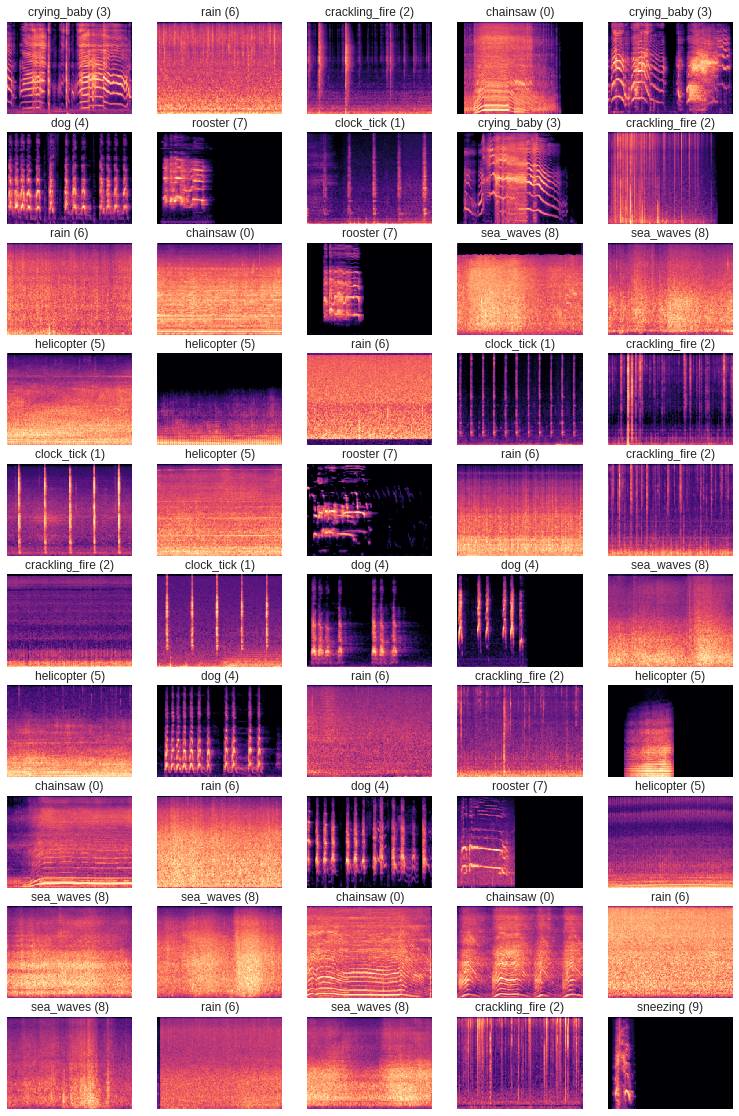

In [0]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

In [0]:
nb_classes = 10

# one-hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


In [0]:
X_train = x_train.reshape((-1,128*216))
X_test = x_test.reshape((-1,128*216))
output_size=X_train.shape[1]
print(output_size)

27648


### Réseau MLP

Dans cette section, vous allez devoir implémenter un réseau dense à 1 ou plusieurs couches cachées

In [0]:
# Model initialization:
model = Sequential()

model.add(Dense(200, input_dim=(output_size)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='sigmoid'))

model.add(Dense(10))
model.add(Activation('softmax'))
# Compléter la ligne suivante en choisissant la bonne fonction de coût.
# Voir la liste des fonctions de coût disponibles ici :
# https://keras.io/losses/

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               5529800   
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 5,550,910
Trainable params: 5,550,910
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compléter les arguments nécessaires ci-dessous
history = model.fit(X_train,Y_train,epochs=100,batch_size=32)

Epoch 1/100
320/320 [==============================] - 1s 3ms/step - loss: 2.2728 - acc: 0.1844
Epoch 2/100
320/320 [==============================] - 0s 554us/step - loss: 2.0808 - acc: 0.3594
Epoch 3/100
320/320 [==============================] - 0s 523us/step - loss: 1.9598 - acc: 0.4250
Epoch 4/100
320/320 [==============================] - 0s 536us/step - loss: 1.8408 - acc: 0.4781
Epoch 5/100
320/320 [==============================] - 0s 523us/step - loss: 1.7389 - acc: 0.5031
Epoch 6/100
320/320 [==============================] - 0s 533us/step - loss: 1.6468 - acc: 0.5312
Epoch 7/100
320/320 [==============================] - 0s 525us/step - loss: 1.5620 - acc: 0.5250
Epoch 8/100
320/320 [==============================] - 0s 575us/step - loss: 1.4636 - acc: 0.5938
Epoch 9/100
320/320 [==============================] - 0s 526us/step - loss: 1.4036 - acc: 0.6125
Epoch 10/100
320/320 [==============================] - 0s 525us/step - loss: 1.3493 - acc: 0.6344
Epoch 11/100
320/320 

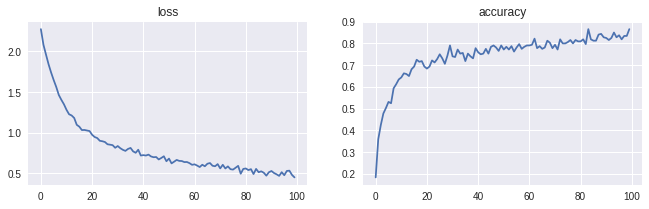

In [0]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

In [0]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 46.25%
CPU times: user 53 ms, sys: 5.98 ms, total: 59 ms
Wall time: 60.7 ms


In [0]:
predictions = model.predict(X_test)

Confusion matrix (rows: true classes; columns: predicted classes):

[[3 0 0 0 0 1 0 0 4 0]
 [0 1 1 0 0 3 1 0 1 1]
 [0 0 5 0 0 1 2 0 0 0]
 [0 0 0 4 0 0 1 2 1 0]
 [0 2 0 1 3 0 0 0 2 0]
 [1 0 3 0 0 3 1 0 0 0]
 [0 0 0 0 0 1 6 0 1 0]
 [0 0 0 2 0 0 0 6 0 0]
 [2 0 0 0 0 2 2 0 2 0]
 [1 0 0 0 0 1 0 1 1 4]]

Classification accuracy for each class:

0: 0.3750
1: 0.1250
2: 0.6250
3: 0.5000
4: 0.3750
5: 0.3750
6: 0.7500
7: 0.7500
8: 0.2500
9: 0.5000


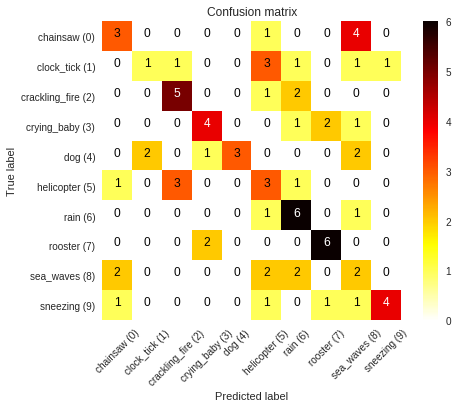

In [0]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))
# afficage de la matrice de confusion dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Réseau convolutif

Maintenant, vous allez implémenter un réseau convolutif.

In [0]:
X_train = x_train.reshape((-1,128,216,1))
X_test = x_test.reshape((-1,128,216,1))

In [0]:
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each (320, 128, 216).
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(128,216,1)))
model.add(Conv2D(62, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(300, input_dim=(output_size)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(100,activation='sigmoid'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='SGD',
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 214, 128)     1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 212, 62)      71486     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 106, 62)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 106, 62)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 104, 32)       17888     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 102, 16)       4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 51, 16)        0         
__________

In [0]:
model.fit(X_train, Y_train, batch_size=32, epochs=25)

Epoch 1/25
320/320 [==============================] - 6s 17ms/step - loss: 2.4691 - acc: 0.1219
Epoch 2/25
320/320 [==============================] - 3s 8ms/step - loss: 2.1233 - acc: 0.2750
Epoch 3/25
320/320 [==============================] - 3s 8ms/step - loss: 1.9360 - acc: 0.3812
Epoch 4/25
320/320 [==============================] - 3s 8ms/step - loss: 1.8228 - acc: 0.4719
Epoch 5/25
320/320 [==============================] - 3s 8ms/step - loss: 1.7298 - acc: 0.5031
Epoch 6/25
320/320 [==============================] - 3s 8ms/step - loss: 1.6811 - acc: 0.5187
Epoch 7/25
320/320 [==============================] - 3s 8ms/step - loss: 1.6133 - acc: 0.5969
Epoch 8/25
320/320 [==============================] - 3s 8ms/step - loss: 1.5517 - acc: 0.6094
Epoch 9/25
320/320 [==============================] - 3s 8ms/step - loss: 1.5097 - acc: 0.5969
Epoch 10/25
320/320 [==============================] - 3s 8ms/step - loss: 1.4701 - acc: 0.6281
Epoch 11/25
320/320 [===========================

In [0]:
predictions = model.predict(X_test)

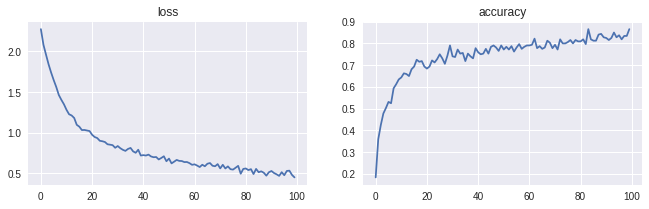

In [0]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

In [0]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 57.50%
CPU times: user 126 ms, sys: 15.7 ms, total: 141 ms
Wall time: 372 ms


Confusion matrix (rows: true classes; columns: predicted classes):

[[2 0 0 0 0 2 0 0 4 0]
 [0 5 1 1 0 1 0 0 0 0]
 [0 4 3 0 0 1 0 0 0 0]
 [0 0 0 6 1 0 0 1 0 0]
 [0 2 0 1 4 0 0 1 0 0]
 [0 0 0 0 0 4 2 0 2 0]
 [0 0 0 1 0 0 6 0 1 0]
 [0 1 0 1 0 0 0 6 0 0]
 [0 0 0 0 0 1 2 0 5 0]
 [0 1 0 0 1 0 0 1 0 5]]

Classification accuracy for each class:

0: 0.2500
1: 0.6250
2: 0.3750
3: 0.7500
4: 0.5000
5: 0.5000
6: 0.7500
7: 0.7500
8: 0.6250
9: 0.6250


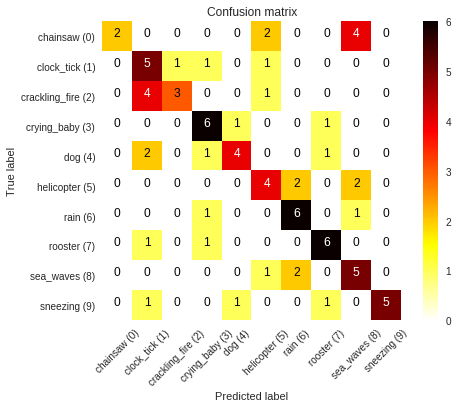

In [0]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))
# afficage de la matrice de confusion dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **VGG16**

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [0]:
VGG16().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
im_width, im_height = 128,216
n_channels = 3

In [0]:
feature_extractor = VGG16(include_top=False, weights='imagenet',input_shape=(128,216,3))
feature_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 216, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 216, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 216, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 108, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 108, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 108, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 54, 128)       0         
__________

In [0]:
base_model = feature_extractor
for layer in base_model.layers[1:4]:
    layer.trainable = False


In [0]:
# définition du modèle
model = Sequential()
model.add(base_model)
# a compléter avec les couches supplémentaires :
model.add(Dense(50,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

model.summary()

# on va utiliser l'optimiseur SGD qui réalise simplement une descente de gradient
# sans utiliser un taux d'apprentissage dynamique.

from keras.optimizers import SGD
model.compile(loss='binary_crossentropy', 
              optimizer='SGD',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 6, 512)         14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 4, 6, 50)          25650     
_________________________________________________________________
dense_8 (Dense)              (None, 4, 6, 25)          1275      
_________________________________________________________________
flatten_2 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                6010      
Total params: 14,747,623
Trainable params: 14,708,903
Non-trainable params: 38,720
_________________________________________________________________


In [0]:
X_train= np.concatenate((x_train[:,:,:,np.newaxis],x_train[:,:,:,np.newaxis],x_train[:,:,:,np.newaxis]),axis=3)
#X_train[:,:,:]= x_train[:,:,:]
#X_train[:,:,:]= x_train[:,:,:]
print(X_train.shape)

(320, 128, 216, 3)


In [0]:
model.fit(X_train, Y_train, batch_size=32, epochs=25)

Epoch 1/25
320/320 [==============================] - 8s 25ms/step - loss: 0.9745 - acc: 0.8634
Epoch 2/25
320/320 [==============================] - 4s 13ms/step - loss: 0.3033 - acc: 0.9034
Epoch 3/25
320/320 [==============================] - 4s 13ms/step - loss: 0.2701 - acc: 0.9075
Epoch 4/25
320/320 [==============================] - 4s 13ms/step - loss: 0.2221 - acc: 0.9194
Epoch 5/25
320/320 [==============================] - 4s 13ms/step - loss: 0.2297 - acc: 0.9244
Epoch 6/25
320/320 [==============================] - 4s 13ms/step - loss: 0.2001 - acc: 0.9281
Epoch 7/25
320/320 [==============================] - 4s 13ms/step - loss: 0.1665 - acc: 0.9391
Epoch 8/25
320/320 [==============================] - 4s 13ms/step - loss: 0.1889 - acc: 0.9387
Epoch 9/25
320/320 [==============================] - 4s 13ms/step - loss: 0.2991 - acc: 0.9100
Epoch 10/25
320/320 [==============================] - 4s 13ms/step - loss: 0.2184 - acc: 0.9222
Epoch 11/25
320/320 [==================

In [0]:
X_test= np.concatenate((x_test[:,:,:,np.newaxis],x_test[:,:,:,np.newaxis],x_test[:,:,:,np.newaxis]),axis=3)
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 94.87%


In [0]:
predictions = model.predict(X_test)

In [0]:
s=0
for num in range(0,79):
  i=np.argmax(Y_test[num])
  j=np.argmax(predictions[num])
  s+=predictions[num][i]
  if(num<10) :
      print("Predicated label :",idx_to_classes[i],"  VS  real label :",idx_to_classes[j])
s/=80
print("real accuracy",s)

Predicated label : dog   VS  real label : dog
Predicated label : helicopter   VS  real label : helicopter
Predicated label : helicopter   VS  real label : helicopter
Predicated label : sea_waves   VS  real label : sea_waves
Predicated label : crackling_fire   VS  real label : rain
Predicated label : rooster   VS  real label : rooster
Predicated label : clock_tick   VS  real label : clock_tick
Predicated label : crackling_fire   VS  real label : clock_tick
Predicated label : crackling_fire   VS  real label : crackling_fire
Predicated label : sea_waves   VS  real label : rain
real accuracy 0.6789594731760805


Confusion matrix (rows: true classes; columns: predicted classes):

[[7 0 0 0 0 0 1 0 0 0]
 [0 7 0 0 0 0 0 0 1 0]
 [0 3 3 0 0 0 2 0 0 0]
 [0 0 0 4 1 0 0 1 0 2]
 [0 0 2 1 4 0 0 0 0 1]
 [0 0 1 0 0 7 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 1 1 0 1 0 0 5 0 0]
 [0 0 0 0 0 0 2 0 6 0]
 [0 0 1 0 1 0 0 0 0 6]]

Classification accuracy for each class:

0: 0.8750
1: 0.8750
2: 0.3750
3: 0.5000
4: 0.5000
5: 0.8750
6: 1.0000
7: 0.6250
8: 0.7500
9: 0.7500


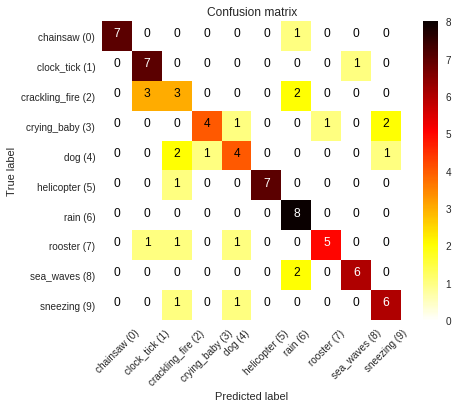

In [0]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))
# afficage de la matrice de confusion dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()